In [2]:
import tensorflow as tf
import scipy
import matplotlib.pyplot as plt
import os
from keras.layers import Conv2D,Rescaling,RandomFlip,RandomRotation,Dense,Flatten,MaxPooling2D,InputLayer,Dropout,RandomZoom,RandomBrightness,RandomTranslation,LeakyReLU,Conv2DTranspose,BatchNormalization,Reshape,Embedding,Concatenate,Input
from keras.losses import SparseCategoricalCrossentropy,BinaryCrossentropy
from keras.utils import plot_model
from keras import Sequential
from keras.optimizers import Adam,SGD,RMSprop
from pathlib import Path
import numpy as np
import copy
from random import randint
import keras
import time

tf.config.list_physical_devices()

2024-09-24 14:21:17.334156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 14:21:17.484456: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 14:21:17.485316: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 14:21:17.697948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 14:21:19.566062: W tensorflow/compiler/tf

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
rescale = Rescaling(scale=1.0/255,name='rescale')
preprocess = lambda x,y: ((x-127.5)/127.5 ,y)
display_model = lambda x: plot_model(x,show_shapes=True)

In [23]:
no_of_class = 102
IMG_SIZE = (120,120)

train = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/train/',image_size=IMG_SIZE,shuffle=False,batch_size=24)
test = tf.keras.utils.image_dataset_from_directory('../102_flowers_dataset/valid/',image_size=IMG_SIZE,shuffle=False,batch_size=24)

train = train.map(preprocess)
test = test.map(preprocess)

Found 6552 files belonging to 102 classes.
Found 818 files belonging to 102 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-09-24 14:21:26.418545: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


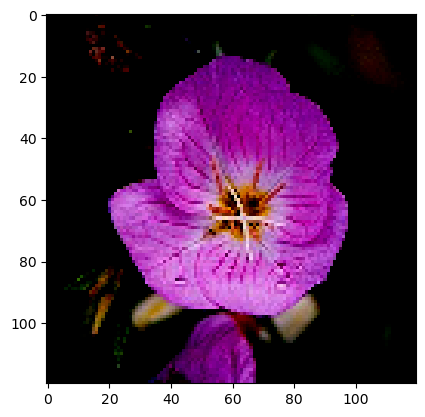

In [5]:
# sampling

for i,j in train.take(1):
    plt.imshow((i[0].numpy()))

In [6]:
def make_discriminator_cond(img: tuple[int],no_of_class:int) -> keras.Model:
    label_input = Input(shape=(1,),name='label_input')
    
    l = Embedding(no_of_class,50,name='label_embedding')(label_input)
    l = Dense(np.prod(img)*3,name='label_dense')(l)
    l = Reshape((img[0], img[1],3),name='label_Reshape')(l)
    
    img_input = Input(shape=(img[0],img[1],3),name='image_input')
    
    merge = Concatenate(name='concatenate')([img_input,l])
    
    x = Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', name='convo_1')(merge)
    x = LeakyReLU(name='Leaky_1')(x)
    x = Dropout(0.1,name='dropout_1')(x)
    
    x = Conv2D(filters=128, kernel_size=(3,3), strides=2, padding='same', name='convo_2')(x)
    x = LeakyReLU(name='Leaky_2')(x)
    x = Dropout(0.1,name='dropout_2')(x)
    
    x = Conv2D(filters=256, kernel_size=(3,3), strides=2, padding='same', name='convo_3')(x)
    x = LeakyReLU(name='Leaky_3')(x)
    x = Dropout(0.1,name='dropout_3')(x)
    
    x = Conv2D(filters=512, kernel_size=(3,3), strides=2, padding='same', name='convo_4')(x)
    x = LeakyReLU(name='Leaky_4')(x)
    x = Dropout(0.1,name='dropout_4')(x)
    
    x = Conv2D(filters=512, kernel_size=(3,3), strides=2, padding='same', name='convo_5')(x)
    x = LeakyReLU(name='Leaky_5')(x)
    x = Dropout(0.1,name='dropout_5')(x)
    x = Flatten(name='flat')(x)
    
    x = Dense(256,name='dense_1',activation='relu')(x)
    x = Dense(128,name='dense_2',activation='relu')(x)
    x = Dense(64,name='dense_3',activation='relu')(x)
    x = Dense(32,name='dense_4',activation='relu')(x)
    x = Dense(16,name='dense_5',activation='relu')(x)
    x = Dense(1, activation='sigmoid', name='final')(x)
    
    discriminator = tf.keras.Model([img_input,label_input],x,name='Conditional_Discriminator')
    
    return discriminator


In [7]:
make_discriminator_cond(IMG_SIZE,no_of_class).summary()

Model: "Conditional_Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 50)     │      5,100 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 43200)  │  2,203,200 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 120, 120,  │          0 │ label_dense[0][0] │
│ (Reshape)           │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 120, 120,  │          0 │ image_input[0][0… │
│ (Concatenate)       │ 6)                │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convo_1 (Conv2D)    │ (None, 60, 60,    │      3,520 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_1 (LeakyReLU) │ (None, 60, 60,    │          0 │ convo_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 60, 60,    │          0 │ Leaky_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convo_2 (Conv2D)    │ (None, 30, 30,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_2 (LeakyReLU) │ (None, 30, 30,    │          0 │ convo_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 30,    │          0 │ Leaky_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convo_3 (Conv2D)    │ (None, 15, 15,    │    295,168 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_3 (LeakyReLU) │ (None, 15, 15,    │          0 │ convo_3[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 15, 15,    │          0 │ Leaky_3[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convo_4 (Conv2D)    │ (None, 8, 8, 512) │  1,180,160 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Leaky_4 (LeakyReLU) │ (None, 8, 8, 512) │          0 │ convo_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 8, 8, 512) │          0 │ Leaky_4[0][0]   

 Total params: 8,261,997 (31.52 MB)

 Trainable params: 8,261,997 (31.52 MB)

 Non-trainable params: 0 (0.00 B)

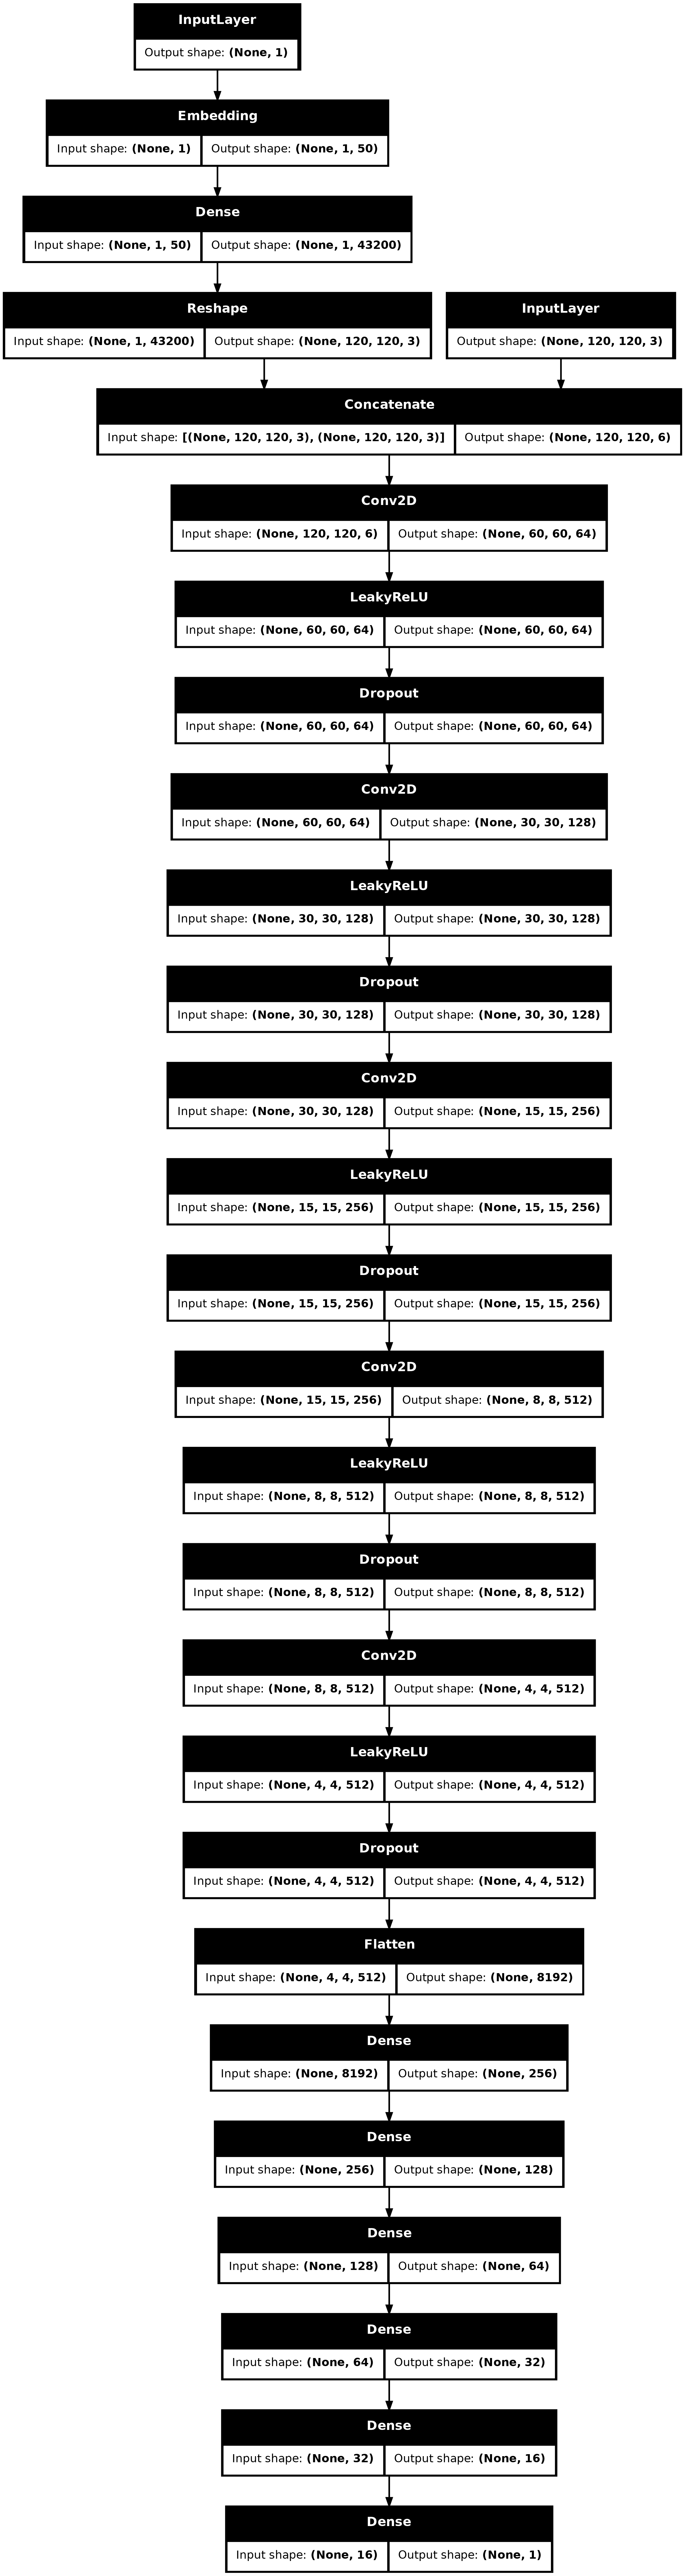

In [8]:
display_model(make_discriminator_cond(IMG_SIZE,no_of_class))

In [9]:
latent_dim = np.array([5,5,512])
noise_shape = 128

def make_generator_cond(no_of_class:int,noise_shape:tuple[int],latent_dim:tuple[int]) -> keras.Model:
    
    label_input = Input(shape=(1,),name='label_input')
    l = Embedding(no_of_class,50,name='label_embedding')(label_input)
    l = Dense(np.cumprod(latent_dim)[-2],name='label_dense')(l)
    l = Reshape(np.append(latent_dim[:-1],[1]),name='label_Reshape')(l)
    
    noise_input = Input(shape=(noise_shape,),name='noise_input')
    n = Dense(np.prod(latent_dim),name='noise_dense')(noise_input)
    n = BatchNormalization(name='norm_1')(n)
    n = LeakyReLU(name='leaky_1')(n)
    n = Reshape(latent_dim,name='noise_reshape')(n)
    
    merge = Concatenate(name='concatenate')([n,l])
    
    x = Conv2DTranspose(512,(3,3),strides=3,padding='same', name='conv_1')(merge)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(name='leaky_2')(x)

    x = Conv2DTranspose(256,(3,3),strides=1,padding='same', name='conv_2')(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(name='leaky_3')(x)

    x = Conv2DTranspose(256,(3,3),strides=2,padding='same', name='conv_3')(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(name='leaky_4')(x)

    x = Conv2DTranspose(128,(3,3),strides=1,padding='same', name='conv_4')(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(name='leaky_5')(x)

    x = Conv2DTranspose(128,(3,3),strides=2,padding='same', name='conv_5')(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(name='leaky_6')(x)

    x = Conv2DTranspose(64,(3,3),strides=1,padding='same', name='conv_6')(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(name='leaky_7')(x)

    x = Conv2DTranspose(3,(3,3),strides=2,padding='same', name='final',activation='tanh')(x)
    
    generator = tf.keras.Model([noise_input,label_input],x,name='Conditional_Generator')
    
    return generator

In [10]:
make_generator_cond(no_of_class,noise_shape,latent_dim).summary()

Model: "Conditional_Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ noise_input         │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_dense (Dense) │ (None, 12800)     │  1,651,200 │ noise_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1              │ (None, 12800)     │     51,200 │ noise_dense[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_embedding     │ (None, 1, 50)     │      5,100 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_1 (LeakyReLU) │ (None, 12800)     │          0 │ norm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_dense (Dense) │ (None, 1, 25)     │      1,275 │ label_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_reshape       │ (None, 5, 5, 512) │          0 │ leaky_1[0][0]     │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_Reshape       │ (None, 5, 5, 1)   │          0 │ label_dense[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 5, 5, 513) │          0 │ noise_reshape[0]… │
│ (Concatenate)       │                   │            │ label_Reshape[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1              │ (None, 15, 15,    │  2,364,416 │ concatenate[0][0] │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_2              │ (None, 15, 15,    │      2,048 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_2 (LeakyReLU) │ (None, 15, 15,    │          0 │ norm_2[0][0]      │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2              │ (None, 15, 15,    │  1,179,904 │ leaky_2[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_3              │ (None, 15, 15,    │      1,024 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_3 (LeakyReLU) │ (None, 15, 15,    │          0 │ norm_3[0][0]      │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3              │ (None, 30, 30,    │    590,080 │ leaky_3[0][0]     │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_4              │ (None, 30, 30,    │      1,024 │ conv_3[0][0]    

 Total params: 6,366,698 (24.29 MB)

 Trainable params: 6,338,410 (24.18 MB)

 Non-trainable params: 28,288 (110.50 KB)

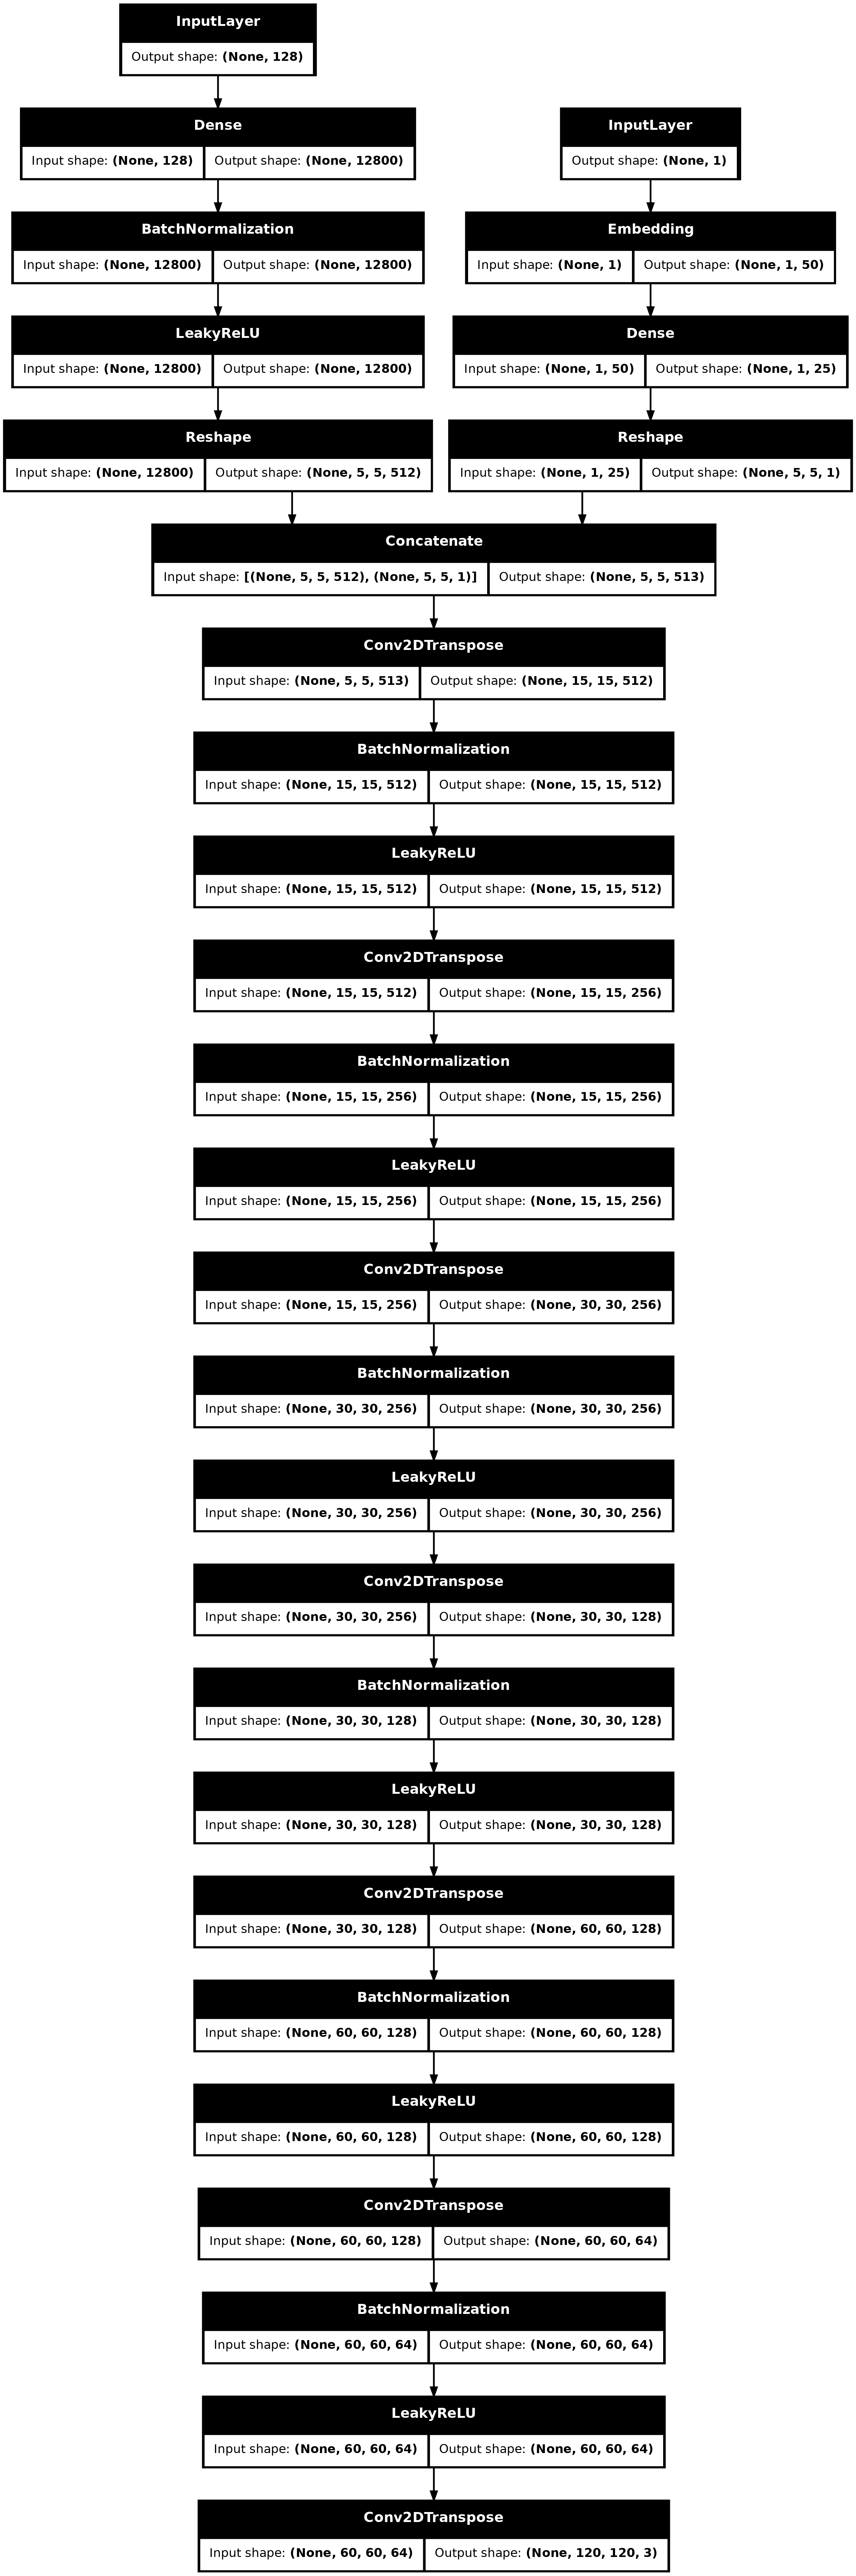

In [11]:
display_model(make_generator_cond(no_of_class,noise_shape,latent_dim))

In [24]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def gen_loss(fake):
    return cross_entropy(tf.ones_like(fake), fake)


def dis_loss(real,fake):
    real_ = cross_entropy(tf.ones_like(real), real)
    fake_ = cross_entropy(tf.zeros_like(fake), fake)
    total = real_ + fake_
    return total

In [29]:
class GAN(tf.keras.Model):
    def __init__(self, latent_dim:np.ndarray,noise_shape:int,img_shape:tuple[int]) -> None:
        super(GAN,self).__init__()
        self.latent_shape = latent_dim
        self.noise_shape = noise_shape
        self.img = img_shape
        self.generator = make_generator_cond(no_of_class,self.noise_shape,self.latent_shape)
        self.discriminator = make_discriminator_cond(self.img,no_of_class)
        self.gen_loss = tf.keras.metrics.Mean(name="generator_loss")
        self.dis_loss = tf.keras.metrics.Mean(name="discriminator_loss")
        
    @property
    def metrics(self):
        return [self.gen_loss,self.dis_loss]
    
    def compile(self,gen_opt,dis_opt):
        super(GAN,self).compile()
        self.gen_opt = gen_opt
        self.dis_opt = dis_opt

        
    def call(self,noise,label):
        gen_img = self.generator([noise,label],training=False)
        return gen_img
    
    @tf.function
    def train_step(self, image):
        noise=  tf.random.normal([24, self.noise_shape])
        img, label = image
        
        label = tf.expand_dims(label,axis=-1)
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated = self.generator([noise,label],training=True)
        
            real = self.discriminator([img,label],training=True)
            fake = self.discriminator([generated,label],training=True)
            gen_loss_ =  gen_loss(fake)
            dis_loss_ = dis_loss(real,fake)
        
        gradients_g = gen_tape.gradient(gen_loss_, self.generator.trainable_variables)
        gradients_d = disc_tape.gradient(dis_loss_, self.discriminator.trainable_variables)

        self.gen_opt.apply_gradients(zip(gradients_g, self.generator.trainable_variables))
        self.dis_opt.apply_gradients(zip(gradients_d, self.discriminator.trainable_variables))

        self.gen_loss.update_state(gen_loss_)
        self.dis_loss.update_state(dis_loss_)
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self):
        try:
            self.generator.save('../saved_weights/gen.keras')
        except:
            print('Error saving the generator')
        
        try:
            self.discriminator.save('../saved_weights/dis.keras')
        except:
            print('Error saving the discriminator')
            
    def load_model(self):
        try:
            self.generator.load_weights('../saved_weights/gen.keras')
        except:
            print('Error loading the generator')
        
        try:
            self.discriminator.load_weights('../saved_weights/dis.keras')
        except:
            print('Error loading the discriminator')
                

In [30]:
gan = GAN(latent_dim,noise_shape,IMG_SIZE)

gen_opt = Adam(learning_rate=0.0005)
dis_opt = Adam(learning_rate=0.00001)

In [31]:
gan.compile(gen_opt,dis_opt)

In [55]:
history=gan.fit(train,epochs=10)

Epoch 1/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 35s 125ms/step - discriminator_loss: 1.3950 - generator_loss: 0.7085
Epoch 2/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - discriminator_loss: 1.3551 - generator_loss: 0.8092
Epoch 3/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - discriminator_loss: 1.2834 - generator_loss: 0.8472
Epoch 4/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - discriminator_loss: 1.3882 - generator_loss: 0.7294
Epoch 5/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - discriminator_loss: 1.3668 - generator_loss: 0.6974
Epoch 6/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - discriminator_loss: 1.3966 - generator_loss: 0.7082
Epoch 7/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - discriminator_loss: 1.3260 - generator_loss: 0.7678
Epoch 8/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 41s 125ms/step - discriminator_loss: 1.2138 - generator_loss: 1.0706
Epoch 9/10
273/273 ━━━━━━━━━━━━━━━━━━━━ 34s 125ms/step - discriminator_loss: 1.1212 - generator_loss: 0.9860
Epoch 10/10
273/273

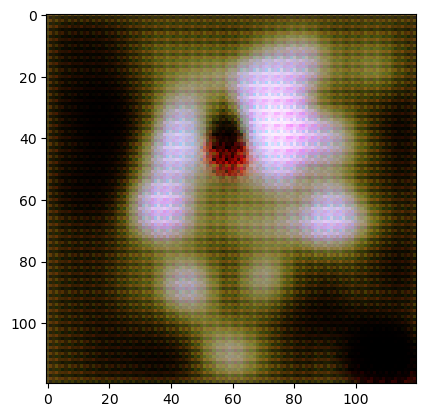

In [62]:
noise=  tf.random.normal([1, noise_shape],seed=5)
label = tf.Variable([1])
pred = gan(noise,label)
plt.imshow((pred[0, :, :, :]+1)/2.0)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


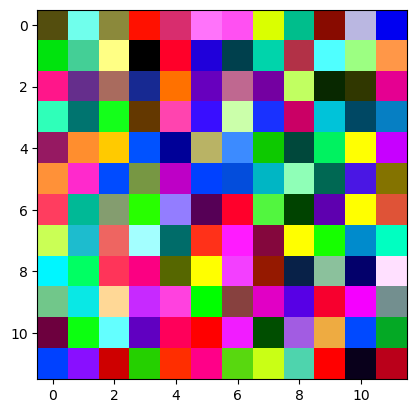

In [64]:
noise=  tf.random.normal([12,12,3],seed=5)


plt.imshow((noise+1)/2.0)

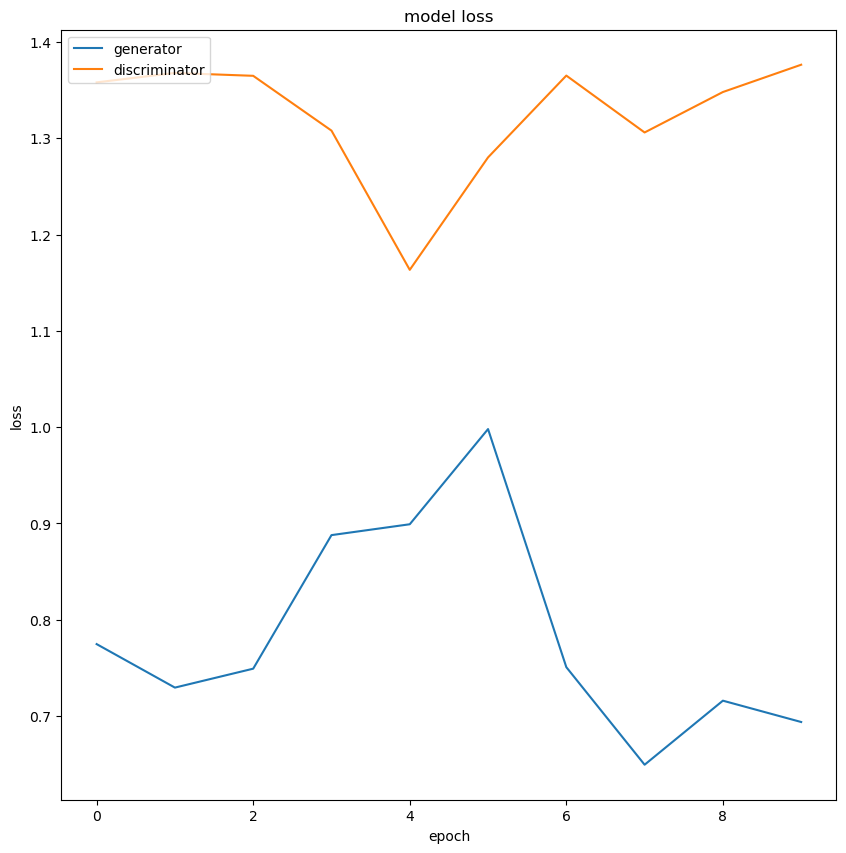

In [43]:
plt.figure(figsize=(10,10))
plt.plot(history.history['generator_loss'])
plt.plot(history.history['discriminator_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()